In [ ]:
# Fraud Detection Using an Autoencoder
#
# TEAM MEMBERS
# Deepesh Kumar Sahu cs23mtech11006
# Naveen Nayak cs23mtech11011
# Pramod Hembrom cs23mtech11015
# Sameer Atram cs23mtech11017

import pandas as pd
import numpy as np
import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from google.colab import drive
import matplotlib.pyplot as plt


In [5]:
class AnomalyDetector(tf.keras.Model):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        tf.random.set_seed(20)
        # np.random.seed(seed)
        self.encoder = tf.keras.Sequential([
            layers.Dense(20, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
            layers.Dense(10, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(20, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/creditcard.csv"



Mounted at /content/drive


In [7]:
data = pd.read_csv(file_path)
# Prepare data
data["LogAmount"] = np.log1p(data["Amount"]+1)
data["LogTime"] = np.log1p(data["Time"]+1)
data.drop(columns=['Time', 'Amount'], inplace=True)
x = data.drop(["Class"], axis=1)
y = data["Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm = x_scale[y == 0]
x_fraud = x_scale[y == 1]

# Split fraud data into train and test sets
X_train_fraud, X_test_fraud = train_test_split(x_fraud, test_size=0.5, random_state=42)

In [8]:
# Define autoencoder architecture
autoencoder = AnomalyDetector(input_dim=x.shape[1])

In [9]:
# Compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# Train the autoencoder
history = autoencoder.fit(x_norm, x_norm,
                           batch_size=256, epochs=1,
                           shuffle=True, validation_split=0.20)

889/889 [==============================] - 5s 3ms/step - loss: 0.0048 - val_loss: 0.0019


In [11]:
reconstructed_data = autoencoder.predict(X_train_fraud)
reconstruction_error = np.mean(np.square(X_train_fraud - reconstructed_data), axis=1)

threshold = 0.001
# # Classify instances as normal or fraud based on the threshold
predictions = np.where(reconstruction_error > threshold, 1, 0)

8/8 [==============================] - 0s 2ms/step


In [12]:
# Evaluate the predictions
true_labels = np.ones(len(X_test_fraud))

f1 = f1_score(true_labels, predictions)

In [13]:
print("F1 Score:", f1)
print("Number of fraud predictions:", np.sum(predictions == 1))
print("Number of non-fraud predictions:", np.sum(predictions == 0))

autoencoder.summary()

F1 Score: 0.9938650306748467
Number of fraud predictions: 243
Number of non-fraud predictions: 3
Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                830       
                                                                 
 sequential_1 (Sequential)   (None, 30)                960       
                                                                 
Total params: 1790 (6.99 KB)
Trainable params: 1790 (6.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


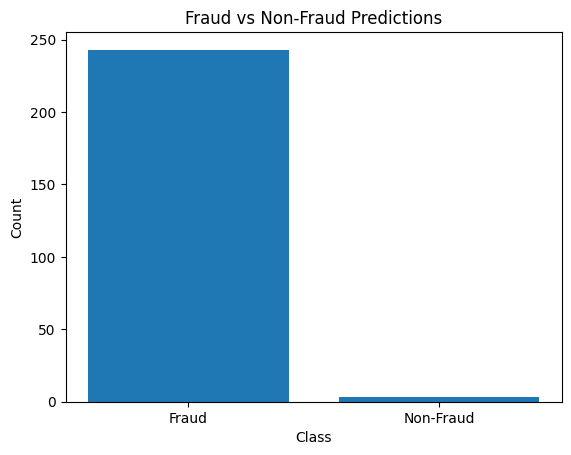

In [14]:
# Count the number of fraud and non-fraud predictions
fraud_count = np.sum(predictions == 1)
non_fraud_count = np.sum(predictions == 0)

# Create a bar plot
plt.bar(['Fraud', 'Non-Fraud'], [fraud_count, non_fraud_count])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Fraud vs Non-Fraud Predictions')
plt.show()

